## Fund Performance Attribution

In this notebook, the *'Washington Mutual Investors Fund' (CWMAX)* fund will be examined by its performance. Different performance metrics will be used to judge the fund returns.

The Washington Mutual Investors Fund mutal fund is US based and searches for companies across a broad spectrum. Mainly, it seeks to find companies with strong balance sheets and consistent dividends. Due to the fund strategy, a natural benchmark index is the S&P 500 with dividends reinvested. 

Fund performance metric methodlogies are listed below.

* Sharpe Ratio
* Elton-Grubers Measure
* Treynor Ratio
* Jensen's Alpha with confidence interval
* Tracking Error
* Information Ratio
* Lobosco's Relative RAP
* Treynor-Mazuy
* Henriksson-Merton
* APT alpha from Fama-French 3 factor model

##### Data Import and Plot Configuration

In [104]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pandas_datareader import data as pdr

fund_data = pdr.get_data_yahoo('CWMAX', start="2002-05-01", end="2022-03-31", interval="d")['Adj Close']
spx_data = pdr.get_data_yahoo('^GSPC', start="2002-05-01", end="2022-03-31", interval="d")['Adj Close']

fama_french_data = pd.read_csv('fama_french_3_factor_data.CSV')
fama_french_data['date'] = pd.to_datetime(fama_french_data['date'], format='%Y%m%d', dayfirst=True)
fama_french_data['date'] = fama_french_data['date']
fama_french_data.set_index(fama_french_data['date'], inplace = True)
fama_french_data.drop(columns=['date'], inplace = True)

fund_returns = np.log(fund_data[1:]/fund_data.shift(1)[1:])
spx_returns = np.log(spx_data[1:]/spx_data.shift(1)[1:])
fama_french_returns = np.log(1 + fama_french_data / 100)

In [105]:
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme()
sns.set_style("whitegrid", {'grid.linestyle': '--'})
seq_col_brew = sns.color_palette("flag_r", 4)
sns.set_palette(seq_col_brew)

##### Data Visualization

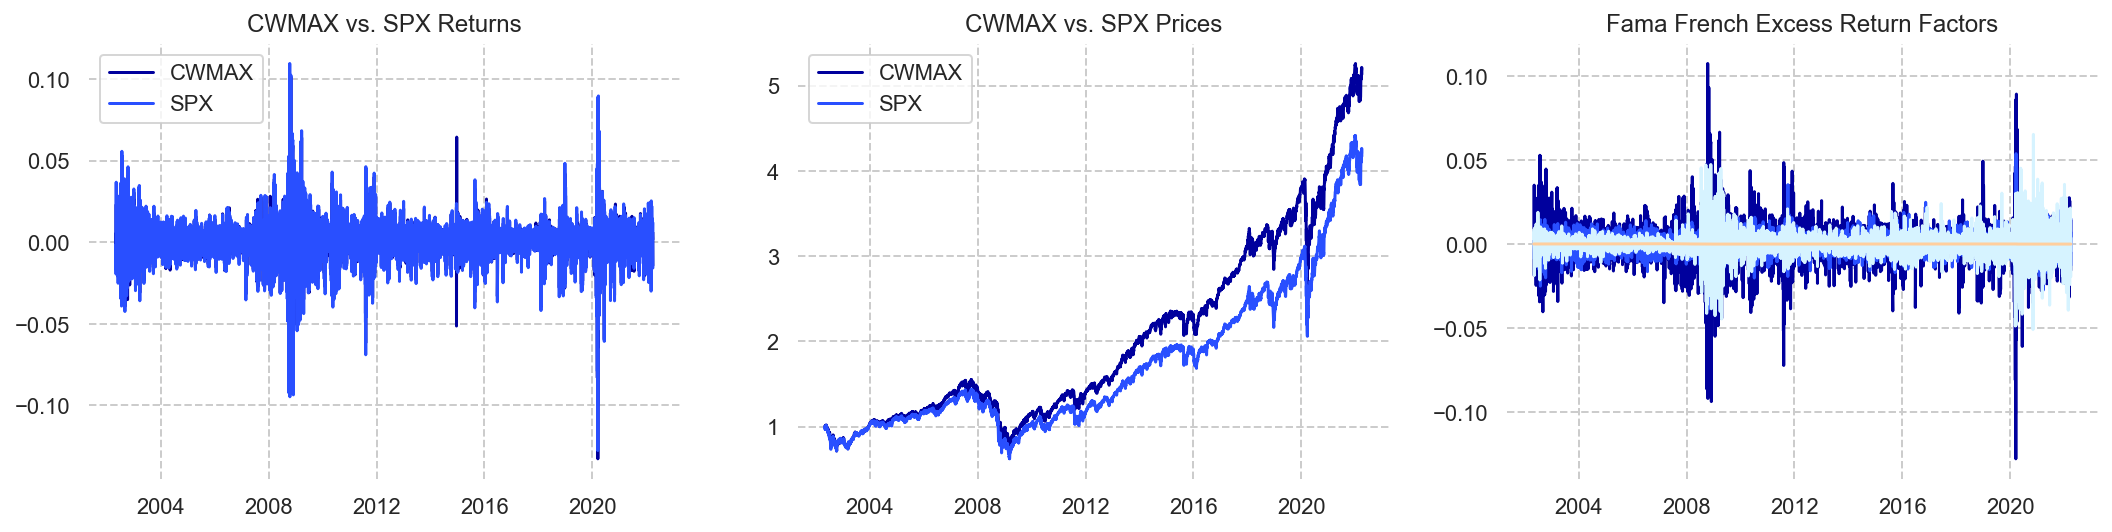

In [106]:
fig, axs = plt.subplots(1, 3)

axs[0].set_title('CWMAX vs. SPX Returns')
axs[0].plot(fund_returns, label = 'CWMAX')
axs[0].plot(spx_returns, label = 'SPX')
axs[0].set_frame_on(False)
axs[0].legend()

axs[1].set_title('CWMAX vs. SPX Prices')
axs[1].plot(fund_data/fund_data[0], label = 'CWMAX')
axs[1].plot(spx_data/spx_data[0], label = 'SPX')
axs[1].set_frame_on(False)
axs[1].legend()

axs[2].set_title('Fama French Excess Return Factors')
axs[2].plot(fama_french_returns)
axs[2].set_frame_on(False)

fig.set_size_inches(18, 4)
plt.show()

##### 1. Sharpe Ratio

The Sharpe ratio, defined below, is sometimes called the risk-adjusted excess returns. It measures the return above the risk-free rate (1M T-bill in this case), per unit volatility. For this ratio, volatility is a proxy for risk.

$$
S = \frac{r_P-r_f}{\sigma_P}
$$

For this we find $r_P$ and $r_f$ by average over the 20Y period. We use the sample standard deviation for $\sigma_P$ for the same period.

In [107]:
fund_mean = np.mean(fund_returns)
fund_std = np.std(fund_returns)

risk_free_mean = np.mean(fama_french_returns['RF'])

fund_sharpe_ratio = (fund_mean - risk_free_mean)/fund_std
print(fund_sharpe_ratio)

0.024565897868257542


##### 2. Elton-Grubers Measure

The Elton-Grubers Measure is a measure of performance. It measures the difference between a portfolio's return on the CML (Capital Market Line) with the same volatility as the target portfolio. In theory, an efficient portfolio with the volatility of the assessed fund will have the return of
$$
\mu_A = r_f + \frac{\mu_M-r_f}{\sigma_M}\sigma_P
$$

The measure then is the ex-post return versus this teoretical return. Namely

$$
\textrm{EG} = \mu_P - \mu_A
$$

In [108]:
market_excess_return = np.mean(fama_french_returns['Mkt-RF'])
market_volatility = np.std(fama_french_returns['Mkt-RF'] + fama_french_returns['RF'])

target_return = risk_free_mean + (market_excess_return) / market_volatility * fund_std
acutal_return = fund_mean

EG = acutal_return - target_return
print(EG)

-2.4143623991421754e-05


##### 3. Treynor Ratio

Similarly to the Sharpe ratio, the Treynor ratio measures excess return per unit of risk. It is displayed below. However, the Treynor index uses the funds beta as a measure of risk, instead of the volatility. 
$$
T = \frac{r_P-r_f}{\beta_P}
$$
In our case, we use all available data to measure the beta. Since our benchmark index is the S&P 500 already, we use that as a proxy for the market portfolio. Recall, the beta can be estimated by
$$
\hat{\beta}_P = \frac{\textrm{Cov}[r_P, r_M]}{\textrm{Var}[r_M]}
$$
However, it is estimated using linear regression below.

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.309e+05
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        02:14:33   Log-Likelihood:                 23581.
No. Observations:                5015   AIC:                        -4.716e+04
Df Residuals:                    5013   BIC:                        -4.714e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.205e-05    3.1e-05      2.000      0.0

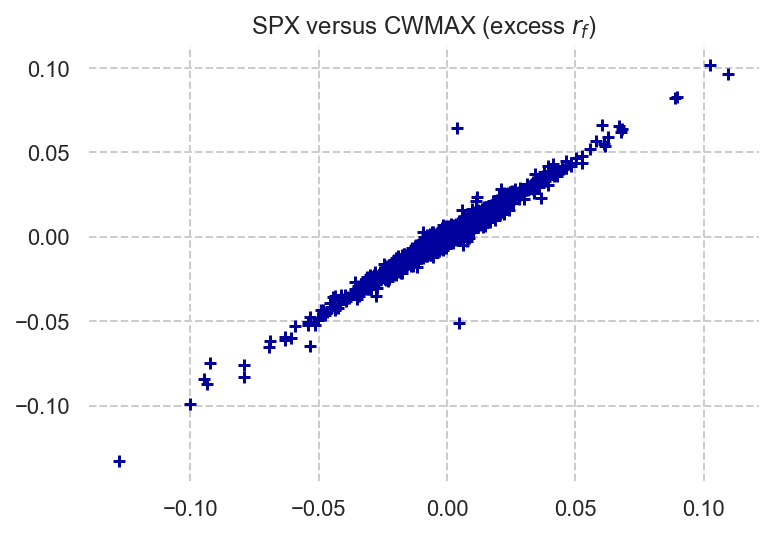

In [112]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

x = spx_returns - fama_french_returns['RF']
y = fund_returns - fama_french_returns['RF']

X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())


plt.scatter(x, y, marker='+')
plt.title('SPX versus CWMAX (excess $r_f$)')
plt.box(False)
plt.show()

In [117]:
fund_beta = est2.params[0]
fund_treynor_ratio = (fund_mean - risk_free_mean) / fund_beta
print(fund_treynor_ratio)

0.0003074615669699502


##### 4. Jensen's Alpha

The alpha, or Jensen's alpha, is the ex-post excess return over what the CAPM predicts. Thus we obtain the alpha as
$$
\alpha = r_P - (r_f + \beta_P(\mu_M - r_f))
$$
The value is most easily found through linear regression. Doing so we also obtain a confidence interval for the value of the intercept, which is the alpha in a regression model.

In [121]:
fund_alpha = est2.params['const']
print(fund_alpha, '±', 3.1e-05)

6.20458285487068e-05 ± 3.1e-05


##### 5. Tracking Error

Tracking error is simply the variance between the spread of the portfolio returns and its benchmark index. If a portfolio aims to track an index this is supposed to be low. If a portfolio on the other hand aims at beating the index, it should not be close to zero. The tracking error is simply found by
$$
\textrm{TE} = \sqrt{\textrm{Var}[r_P - r_A]} 
$$

In [122]:
tracking_error_fund = np.std(fund_returns - spx_returns)
print(tracking_error_fund)

0.002439545034778632


##### 6. Information Ratio

The information ratio can be thought of as a measure of risk-adjusted alpha. It measures the excess return, alpha, with the tracking error. It is calcuted as shown below
$$
\textrm{IR} = \frac{\alpha_P}{\textrm{TE}}
$$
Using the information ratio in relation to the alpha, we can also estimate how many years are required to tell whether or not the alpha is statistically significant. This is done with 
$$
T_{\textrm{req}} = (\frac{t_{\textrm{stat}}}{\textrm{IR}})^2
$$

In [123]:
information_ratio_fund = fund_alpha / tracking_error_fund
t_req = (1.96 / information_ratio_fund) ** 2
print(information_ratio_fund, 'with time req. for significant alpha', t_req)

0.025433360591491164 with time req. for significant alpha 5938.881302497973


##### 7. Lobosco Relative RAP

Lobosco's (1999) relative RAP starts with solving mean market returns from the CAPM. That is, the fund returns imply some market return. This can be done for a benchmark portfolio as well. And then relative RAP can be found. Thus
$$
\textrm{RAP}_i = \frac{\sigma_M}{\sigma_i}(\mu_i - r_f) + r_f
$$
and 
$$
\textrm{Relative RAP} = \textrm{RAP}_P - \textrm{RAP}_B
$$

In [124]:
rap_fund = market_volatility / fund_std * (fund_mean - risk_free_mean) + risk_free_mean
rap_bench = market_excess_return + risk_free_mean

relative_rap = rap_fund - rap_bench
print(relative_rap)

-2.606809891512237e-05


##### 8. Treynor-Mazuy

Both Treynor-Mazuy and Henriksson-Merton, tries to estimate the market timing of the portfolio manager. The hypothesis is that if a portfolio manager has market timing, he/she will reduce the market beta during market downturns, and increase it during market upturns. This is estimated by adding a term in a linear regression model for large returns. Large returns explaining part of the return provides evidence in favour of this hypothesis.

Treynor-Mazuy came up with the regression model given below
$$
(r_P - r_f) = \alpha + \beta_0 (r_M - r_f) + \beta_1 (r_M - r_f)^2 + \varepsilon_t
$$
if $\beta_1 > 0$ significantly, the portfolio manager has good market timing.

In [137]:
y = fund_returns - fama_french_returns['RF']
x = spx_returns - fama_french_returns['RF']
x_squared = x ** 2

X = pd.DataFrame(x, columns = ['x'])
X['x squared'] = x_squared
X = sm.add_constant(X)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 6.564e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        02:22:02   Log-Likelihood:                 23589.
No. Observations:                5015   AIC:                        -4.717e+04
Df Residuals:                    5012   BIC:                        -4.715e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.504e-05   3.21e-05      2.963      0.0

In [144]:
print(est2.params[2], 'statistically significant.')

-0.21683562441558799 statistically significant.


##### 9. Henriksson-Merton

As mentioned in (8), Henriksson-Merton also tries to measure market timing, but for market downturns exclusivley, and without making use of quadratics (which are not realistic). Their regression model is displayed below
$$
(r_P - r_f) = \alpha + \beta_0 (r_M - r_f) + \beta_1 D_t(r_M - r_f) + \varepsilon_t
$$
in which $D(t)$ is defined as
$$
  D_t \triangleq \begin{cases}
    0, & \text{$(r_M-r_f) \geq 0 $}\\
    -1, & \text{$(r_M-r_f) < 0$}
  \end{cases}
$$

In [148]:
y = fund_returns - fama_french_returns['RF']
x = spx_returns - fama_french_returns['RF']
D = [-1 if ret < 0 else 0 for ret in x]

X = pd.DataFrame(x, columns = ['x'])
X['d'] = x * D
X = sm.add_constant(X)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 6.548e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        03:03:10   Log-Likelihood:                 23583.
No. Observations:                5015   AIC:                        -4.716e+04
Df Residuals:                    5012   BIC:                        -4.714e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001   4.06e-05      2.905      0.0

In [150]:
print(est2.params[2], 'statistically significant')

-0.014111443372309004 statistically significant


##### 10. Fama-French Alpha

As evidenced by the APT result, regression models with high $R^2$, should have a low, or zero alpha. Fama-French used two different portfolios beyond the market portfolio to explain a stock's return. By running the regression we are able to see if an excess return beyond the APT is generated, and to which risk-factors we are exposed to (of the ones in the Fama-French 3 factor model).

The Fama-French 3 factor model is simply an approximation of APT, estimated by the linear regression model below.
$$
(r_P - r_f) = \alpha + \beta_0 (r_M - r_f) + \beta_1 SML + \beta_2 HML + \varepsilon_t
$$

The idea is that value stocks (in the days of Fama and French) outperformed growth stocks and small cap stocks outperform large cap stocks. This means investors get compensated by assuming the additional risk these kinds of stocks have. Returns are thus better explained by including the exposures to these kind of stocks. For this purpose wide portfolios of stocks of the aforementioned categories were created, and returns thereof calculated. The categories explain the abreviations above.

* SML - Small cap. minus Large cap.
* HML - High value minus Low value 

In [158]:
y = fund_returns - fama_french_returns['RF']
x = fama_french_returns[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                 4.186e+04
Date:                Mon, 09 May 2022   Prob (F-statistic):               0.00
Time:                        03:13:57   Log-Likelihood:                 23482.
No. Observations:                5015   AIC:                        -4.696e+04
Df Residuals:                    5011   BIC:                        -4.693e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.258e-06   3.17e-05     -0.229      0.8

In [159]:
print(est2.params[0], 'statistically insignificant')

-7.258203772667213e-06 statistically insignificant
